## Large objects with protrusions

In this example, inspired by this Image.sc [question](https://forum.image.sc/t/challenging-segmentation-with-cellpose-need-help/103618) we try to finetune Cellpose to segment large objects with long protrusions.

num inputs:  1
num ground truth:  1
image label paths [WindowsPath('C:/Users/bnort/work/ImageJ2022/tnia/notebooks-and-napari-widgets-for-dl/data/protrusions/labels/input0')]
ground_truth_label_paths C:\Users\bnort\work\ImageJ2022\tnia\notebooks-and-napari-widgets-for-dl\data\protrusions\labels\ground truth0


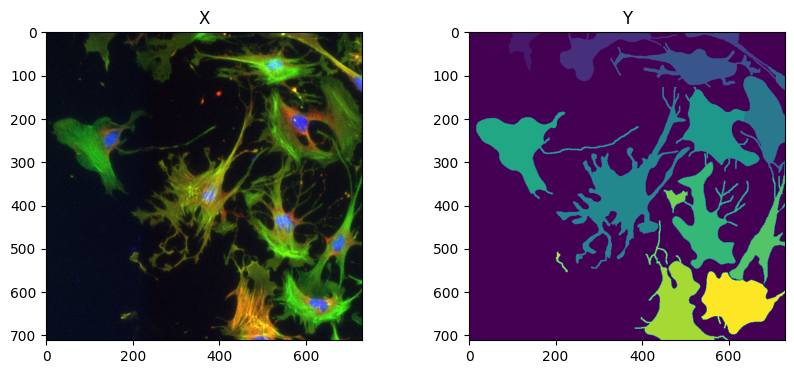

In [4]:
from skimage.io import imread
from tnia.deeplearning.dl_helper import quantile_normalization, get_label_paths
from tnia.plotting.plt_helper import imshow_multi2d
import json
import os
from skimage.measure import label
from cellpose import models, io

data_path = r'../../data'
parent_path = os.path.join(data_path, 'protrusions')
label_path = os.path.join(parent_path, 'labels')

# open the info file
json_name = os.path.join(label_path, 'info.json')
json_ = json.load(open(json_name))

# get number of inputs and number of ground truths for this problem
num_inputs = json_['num_inputs']
num_ground_truths = json_['num_truths']
print('num inputs: ', num_inputs)   
print('num ground truth: ', num_ground_truths)

image_label_paths, ground_truths_label_paths = get_label_paths(1, num_ground_truths, label_path)
print('image label paths',image_label_paths)
print("ground_truth_label_paths", ground_truths_label_paths[0])

X = imread(os.path.join(image_label_paths[0], 'img153_0.tif'))
Y = imread(os.path.join(ground_truths_label_paths[0], 'img153_0.tif'))

X = quantile_normalization(X, channels=True)
Y = label(Y)

fig = imshow_multi2d([X, Y], ['X', 'Y'], 1, 2)



creating new log file
2024-10-25 20:04:35,397 [INFO] WRITING LOG OUTPUT TO C:\Users\bnort\.cellpose\run.log
2024-10-25 20:04:35,398 [INFO] 
cellpose version: 	3.0.9 
platform:       	win32 
python version: 	3.10.14 
torch version:  	2.2.2+cu118


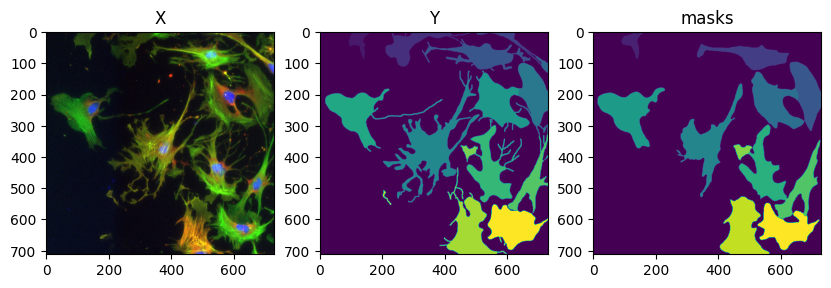

In [2]:
model_cyto3 = models.CellposeModel(gpu=True, model_type="cyto3")
model_finetuned_defaults = models.CellposeModel(gpu=True, model_type="cyto3")
model_finetuned_no_rescale = models.CellposeModel(gpu=True, model_type="cyto3")
model_finetuned_no_rescale_bsize_512 = models.CellposeModel(gpu=True, model_type="cyto3")

logger = io.logger_setup()

masks = model_cyto3.eval(X, diameter=100, channels=[2,3])
fig = imshow_multi2d([X, Y, masks[0]], ['X', 'Y', 'masks'], 1, 3)


## Replicate training image to minimize 'randomness' in training

Here we copy the training data 100 times.  Cellpose training has a built in augmentation step (which I don't think we can turn off through the API.. correct me if I missed this option).  Thus if we only have 1 training image, each epoch will consist of 1 augmented image, and the model at the end of an epoch can be randomly different depending on the augmentation... however if we present 100 of the same images, an epoch will consist of 100 random augmentations, thus minimizing the randomness.  

In [5]:
X_list = [X]*100
Y_list = [Y]*100

print(len(X_list))

100


In [38]:
from cellpose import train

train.train_seg( model_finetuned_no_rescale.net, X_list, Y_list,   
                channels=[2,3], 
                save_path=parent_path, 
                n_epochs=500,
                min_train_masks=0,
                rescale = False,  
                model_name='no_rescale',
                normalize=False)

2024-10-26 06:37:55,489 [INFO] computing flows for labels


100%|██████████| 100/100 [00:28<00:00,  3.57it/s]

2024-10-26 06:38:23,640 [INFO] >>> computing diameters



100%|██████████| 100/100 [00:00<00:00, 421.16it/s]

2024-10-26 06:38:23,881 [INFO] >>> using channels [2, 3]


2024-10-26 06:38:24,448 [INFO] >>> n_epochs=200, n_train=100, n_test=None
2024-10-26 06:38:24,450 [INFO] >>> AdamW, learning_rate=0.00500, weight_decay=0.00001
2024-10-26 06:38:24,452 [INFO] >>> saving model to C:\Users\bnort\work\ImageJ2022\tnia\notebooks-and-napari-widgets-for-dl\data\protrusions\models\no_rescale
2024-10-26 06:38:26,875 [INFO] 0, train_loss=0.2434, test_loss=0.0000, LR=0.0000, time 2.42s
2024-10-26 06:38:38,890 [INFO] 5, train_loss=0.2466, test_loss=0.0000, LR=0.0028, time 14.44s
2024-10-26 06:38:50,857 [INFO] 10, train_loss=0.2546, test_loss=0.0000, LR=0.0050, time 26.41s
2024-10-26 06:39:14,255 [INFO] 20, train_loss=0.2458, test_loss=0.0000, LR=0.0050, time 49.80s
2024-10-26 06:39:37,033 [INFO] 30, train_loss=0.2401, test_loss=0.0000, LR=0.0050, time 72.58s
2024-10-26 06:39:59,496 [INFO] 40, train_loss=0.2438, test_loss=0.0000, LR=0.0050, time 95.04s
2024-10-26 06:40:22,067 [INFO] 50, train_loss=0.2290, test_loss=0.0000, LR=0.0050, time 117.62s
2024-10-26 06:40:44

WindowsPath('C:/Users/bnort/work/ImageJ2022/tnia/notebooks-and-napari-widgets-for-dl/data/protrusions/models/no_rescale')

In [20]:
train.train_seg( model_finetuned_no_rescale_bsize_512.net, X_list, Y_list,   
                channels=[2,3], 
                save_path=parent_path, 
                n_epochs=500,
                min_train_masks=0,
                rescale = False,  
                model_name='no_rescale_bsize_512',
                normalize=False,
                bsize=512)

2024-10-25 21:34:47,714 [INFO] computing flows for labels


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]

2024-10-25 21:35:13,606 [INFO] >>> computing diameters



100%|██████████| 100/100 [00:00<00:00, 407.59it/s]

2024-10-25 21:35:13,855 [INFO] >>> using channels [2, 3]


2024-10-25 21:35:14,391 [INFO] >>> n_epochs=200, n_train=100, n_test=None
2024-10-25 21:35:14,393 [INFO] >>> AdamW, learning_rate=0.00500, weight_decay=0.00001
2024-10-25 21:35:14,397 [INFO] >>> saving model to C:\Users\bnort\work\ImageJ2022\tnia\notebooks-and-napari-widgets-for-dl\data\protrusions\models\no_rescale_bsize_512
2024-10-25 21:35:21,599 [INFO] 0, train_loss=0.1079, test_loss=0.0000, LR=0.0000, time 7.20s
2024-10-25 21:35:58,652 [INFO] 5, train_loss=0.1066, test_loss=0.0000, LR=0.0028, time 44.26s
2024-10-25 21:36:36,469 [INFO] 10, train_loss=0.1090, test_loss=0.0000, LR=0.0050, time 82.07s
2024-10-25 21:37:53,347 [INFO] 20, train_loss=0.1064, test_loss=0.0000, LR=0.0050, time 158.95s
2024-10-25 21:39:10,593 [INFO] 30, train_loss=0.1042, test_loss=0.0000, LR=0.0050, time 236.20s
2024-10-25 21:40:27,608 [INFO] 40, train_loss=0.1010, test_loss=0.0000, LR=0.0050, time 313.21s
2024-10-25 21:41:44,177 [INFO] 50, train_loss=0.0975, test_loss=0.0000, LR=0.0050, time 389.78s
2024-1

WindowsPath('C:/Users/bnort/work/ImageJ2022/tnia/notebooks-and-napari-widgets-for-dl/data/protrusions/models/no_rescale_bsize_512')

In [21]:
train.train_seg( model_finetuned_defaults.net, X_list, Y_list,   
                channels=[2,3], 
                save_path=parent_path, 
                n_epochs=500,
                min_train_masks=0,
                model_name='defaults',
                normalize=False)

2024-10-25 22:03:00,623 [INFO] computing flows for labels


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

2024-10-25 22:03:26,180 [INFO] >>> computing diameters



100%|██████████| 100/100 [00:00<00:00, 434.06it/s]

2024-10-25 22:03:26,417 [INFO] >>> using channels [2, 3]


2024-10-25 22:03:26,914 [INFO] >>> n_epochs=200, n_train=100, n_test=None
2024-10-25 22:03:26,915 [INFO] >>> AdamW, learning_rate=0.00500, weight_decay=0.00001
2024-10-25 22:03:26,918 [INFO] >>> saving model to C:\Users\bnort\work\ImageJ2022\tnia\notebooks-and-napari-widgets-for-dl\data\protrusions\models\defaults
2024-10-25 22:03:29,286 [INFO] 0, train_loss=0.0798, test_loss=0.0000, LR=0.0000, time 2.37s
2024-10-25 22:03:40,945 [INFO] 5, train_loss=0.0786, test_loss=0.0000, LR=0.0028, time 14.03s
2024-10-25 22:03:52,542 [INFO] 10, train_loss=0.0788, test_loss=0.0000, LR=0.0050, time 25.62s
2024-10-25 22:04:16,297 [INFO] 20, train_loss=0.0779, test_loss=0.0000, LR=0.0050, time 49.38s
2024-10-25 22:04:39,360 [INFO] 30, train_loss=0.0773, test_loss=0.0000, LR=0.0050, time 72.44s
2024-10-25 22:05:02,300 [INFO] 40, train_loss=0.0758, test_loss=0.0000, LR=0.0050, time 95.38s
2024-10-25 22:05:25,183 [INFO] 50, train_loss=0.0744, test_loss=0.0000, LR=0.0050, time 118.27s
2024-10-25 22:05:48,1

WindowsPath('C:/Users/bnort/work/ImageJ2022/tnia/notebooks-and-napari-widgets-for-dl/data/protrusions/models/defaults')

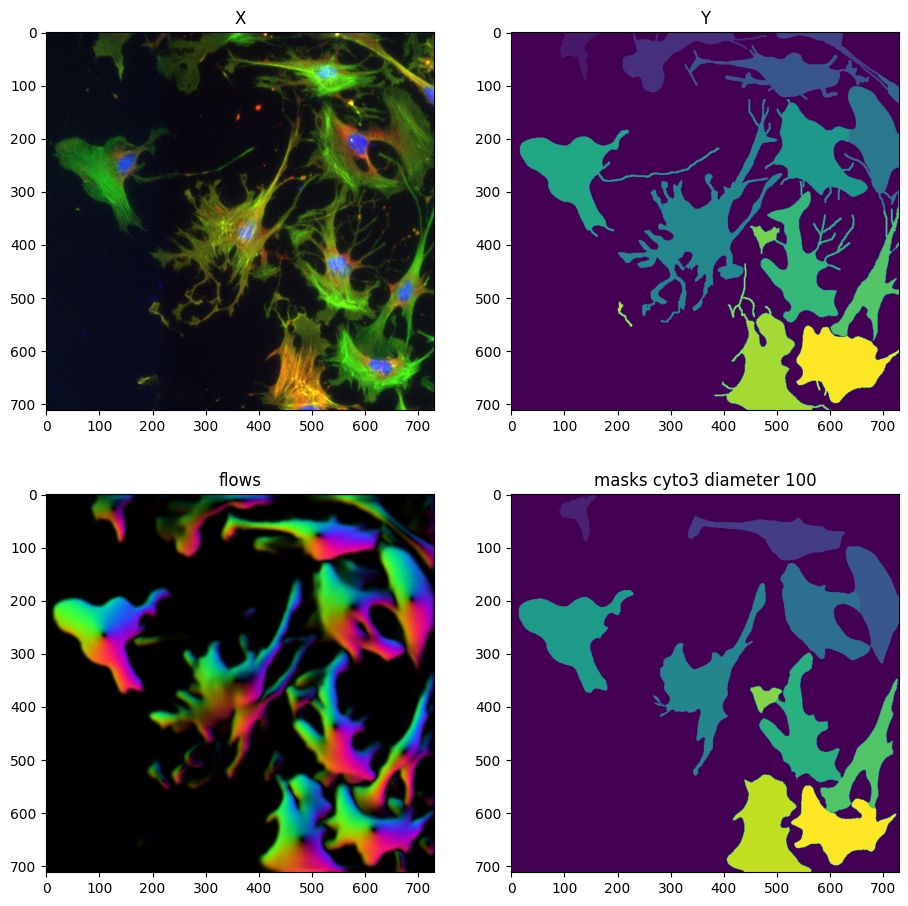

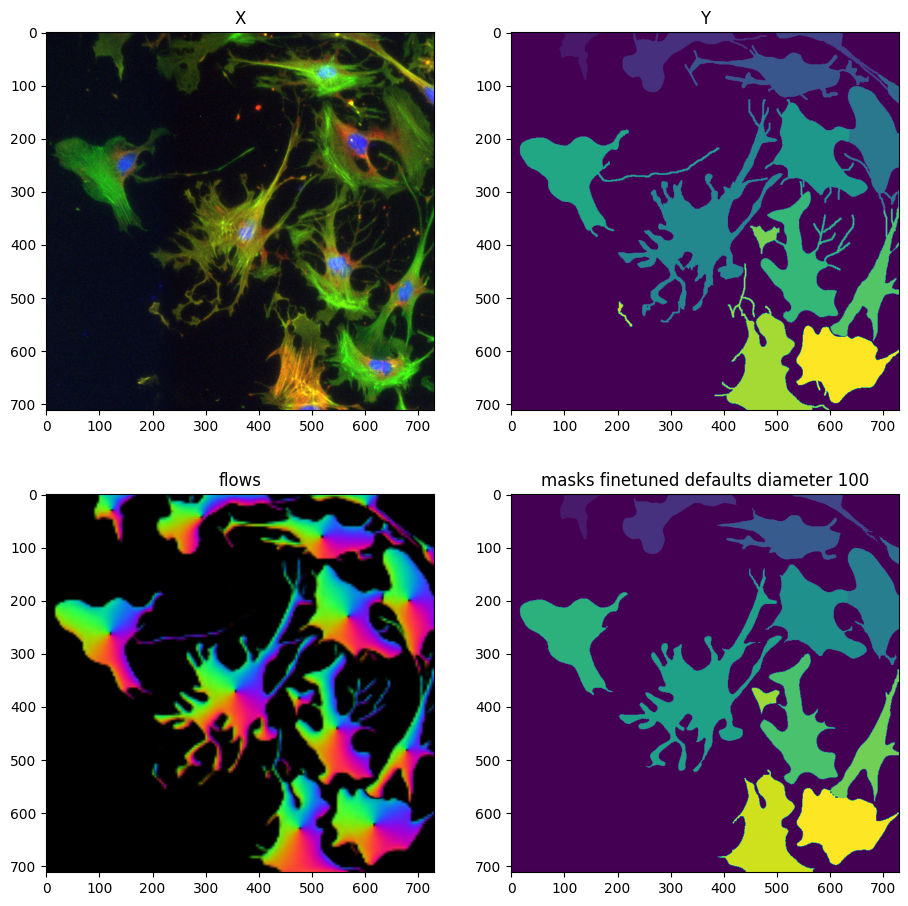

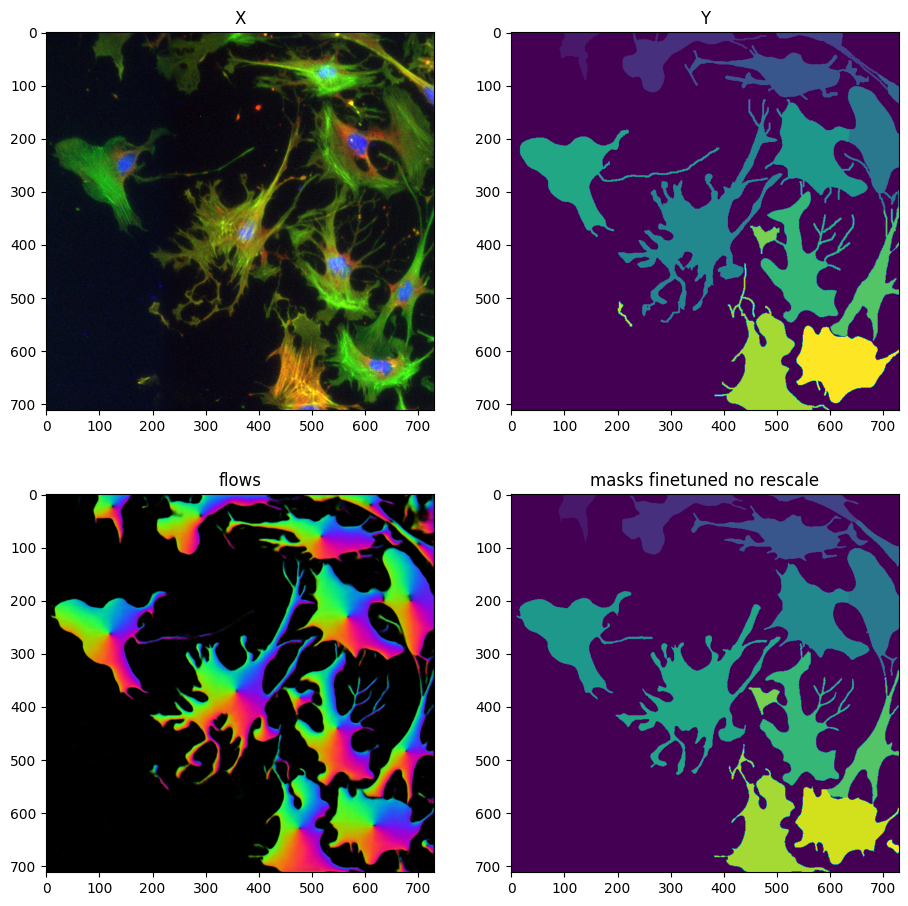

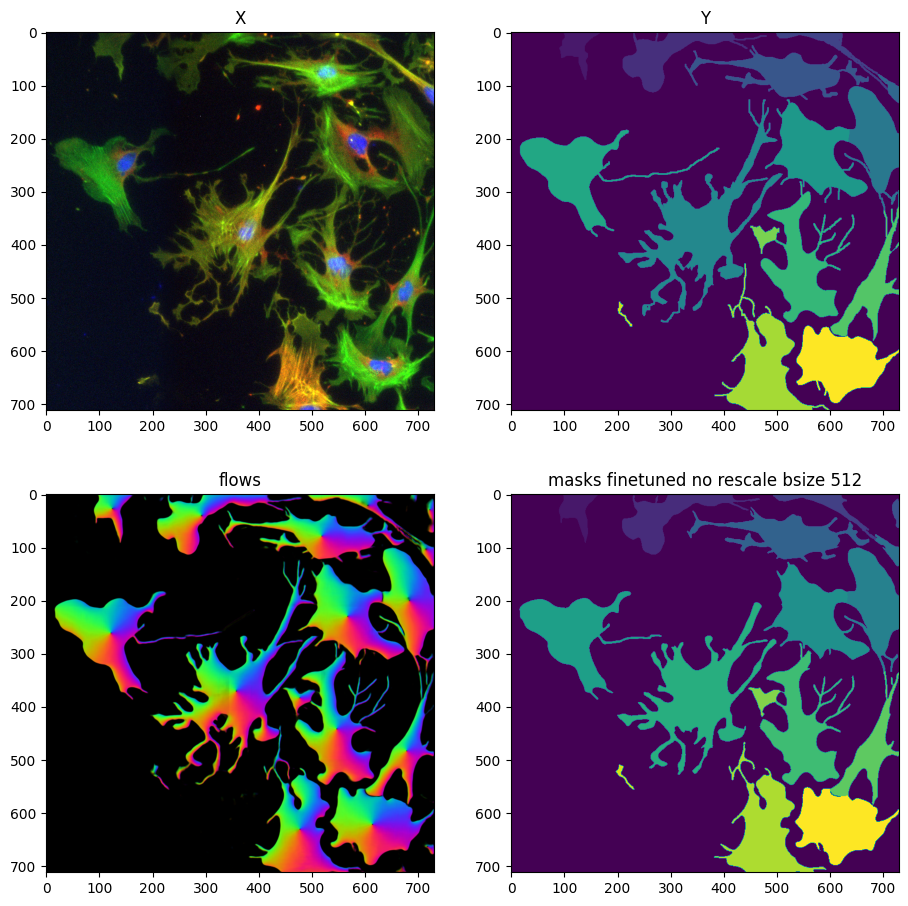

In [39]:
masks = model_cyto3.eval(X, diameter=100, channels=[2,3])
fig = imshow_multi2d([X, Y, masks[1][0], masks[0]], ['X', 'Y', 'flows', 'masks cyto3 diameter 100'], 2, 2, width=11, height=11)

masks_defaults = model_finetuned_defaults.eval(X, diameter=130, channels=[2,3], normalize=False)
fig = imshow_multi2d([X, Y, masks_defaults[1][0], masks_defaults[0]], ['X', 'Y', 'flows', 'masks finetuned defaults diameter 100'], 2, 2, width=11, height=11)

masks_no_rescale = model_finetuned_no_rescale.eval(X, channels=[2,3], normalize=False)
fig = imshow_multi2d([X, Y, masks_no_rescale[1][0], masks_no_rescale[0]], ['X', 'Y', 'flows', 'masks finetuned no rescale'], 2, 2, width=11, height=11)

masks_no_rescale_bsize_512 = model_finetuned_no_rescale_bsize_512.eval(X, channels=[2,3], cellprob_threshold=-1.0, normalize=False)
fig = imshow_multi2d([X, Y, masks_no_rescale_bsize_512[1][0], masks_no_rescale_bsize_512[0]], ['X', 'Y', 'flows', 'masks finetuned no rescale bsize 512'], 2, 2, width=11, height=11)


In [33]:
import napari

viewer = napari.Viewer()

viewer.add_image(masks_no_rescale_bsize_512[0], name='prediction')
viewer.add_image(masks_no_rescale_bsize_512[1][0], name='flow')
#viewer.add_image(masks_no_rescale_bsize_512[2], name='what')

<Image layer 'flow' at 0x11bff80e800>